**Phase separation induced by interaction between herbivore and plant**

**Copyright: Zhenpeng Ge, Quan-xing Liu**

**Licence: MIT Licence**

**An example to plot a similar figure like to Figure 4B in the paper**

In [69]:
from __future__ import absolute_import, print_function
import time
import numpy as np
import pyopencl as cl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import signal
from matplotlib import rcParams
import scipy.io as io
import os

In [70]:
# Widening the screen
from IPython.core.display import display
from IPython.display import HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

rcParams['figure.dpi'] = 600
rcParams['font.size'] = 16
rcParams['font.family'] = 'dejavuserif' # dejavuserif, stixsans, cm, StixGeneral
# rcParams['text.usetex'] = True
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)   # fontsize of the figure title

**Spatial setting**

In [71]:
length    = 1024.0      # Length of the physical landscape
n         = 1024        # Size of the 2D grid
dX          = length/n      # Spatial step size
dY          = length/n      # Spatial step size
Grid_Width  = n
Grid_Height = n
# %% Reporting in the simulation on the console
print(" Current grid dimensions: %d x %d cells\n" % (Grid_Width, Grid_Height));

 Current grid dimensions: 1024 x 1024 cells



**Time setting**

In [72]:
endtime   = 5000.0       # end time 20000.0
dT        = 0.02          # calculate time step
nplot     = 100           # Sample number 
nsteps    = np.ceil(endtime/nplot/dT).astype(int)    # number of time steps: endtime/dT

**Defining the device that is used**

In [73]:
# Setting up the OpenCL context
DeviceNr = 1   # 0 = NVIDIA GPU, try 1 or 2 for AMD GPU
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'
platform = cl.get_platforms()
Devices  = platform[0].get_devices()  # 0 = GPU
context  = cl.Context([Devices[DeviceNr]])
queue    = cl.CommandQueue(context)
mf       = cl.mem_flags # Memory flags are set
print(" Compute Device: %s\n" % Devices[DeviceNr].name)

 Compute Device: AMD Radeon Pro 5700 XT Compute Engine



**Parameter definition** 

In [74]:
# parameters
D0        =  1                #  The diffusivity parameter on H
DP        =  1                #  The diffusivity parameter on P
lambda0   =  1                #  Growth rate of plants 
kappa     =  0.05             #  Tensor coefficients 
# alpha    =   0.5              #  behavior Coefficient
beta      =  0.1              #  behavior Coefficient

# H_biomass=0.65                #  spatial average herbivore biomass
H_max     =  0.95
H_min     =  0.3
alpha_max =  5.0
alpha_min =  2.5

**Initial values**

In [75]:
DataType=np.float32
# The array is allocated on the GPU and the initial values are copied onto it
Temp              = np.tile(np.linspace(H_min,H_max,n),n)  # np.tile(np.logspace(np.log10(S0_min),np.log10(S0_max),n),n)
# H
H                 = (2*np.random.rand(n*n)-1)* 0.01+Temp
H_host            = H.astype(DataType)
H_g               = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=H_host) # copy data to GPU
# P
P                 = (2*np.random.rand(n*n)-1)* 0.01+1.0-Temp/lambda0
P_host            = P.astype(DataType)
P_g               = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=P_host)
# CoeffH
CoeffH            = H*0.0
CoeffH_host       = CoeffH.astype(DataType)
CoeffH_g          = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=CoeffH_host)
# CoeffP
CoeffP            = P*0.0
CoeffP_host       = CoeffP.astype(DataType)
CoeffP_g          = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=CoeffP_host)
# TH
TH                = H*0.0
TH_host           = TH.astype(DataType)
TH_g              = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=TH_host)
#parameter ->array
#Da array -> GPU
alpha             = np.linspace(alpha_max,alpha_min,n).repeat(n) #np.logspace(np.log10(3.3),np.log10(0.3),n).repeat(n)#np.logspace(np.log10(3.3),np.log10(0.3),n).repeat(n)#0.85
alpha_host        = alpha.astype(DataType)
alpha_g           = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=alpha_host)

**Defining the OpenCL simulation kernel**

In [76]:
# List of parameters for the OpenCL kernel. Seperate with comma without spaces
# Setting up the parameters for the Kernel
PassVars="D0,DP,lambda0,kappa,beta,dX,dY,dT,Grid_Width,Grid_Height"
PassVals=eval(PassVars)
PassVars=PassVars.split(',')
Params=""
for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"

In [77]:
ComputeCode = """

////////////////////////////////////////////////////////////////////////////////
// Laplacation operator definition, to calculate diffusive fluxes
////////////////////////////////////////////////////////////////////////////////

static float d2_dxy2(__global float* pop)
{
    // Getting thread coordinates on the grid
    size_t current = get_global_id(0);
    size_t row     = (size_t)(current/Grid_Width);
    size_t column  = current%Grid_Width;
    
    // Computing positions of the neighbors
    size_t left    = row * Grid_Width + column-1;
    size_t right   = row * Grid_Width + column+1;
    size_t top     = (row-1) * Grid_Width + column;
    size_t bottom  = (row+1) * Grid_Width + column;
    
    float retval = ( (pop[left] - 2.0*pop[current] + pop[right]) )
                     /(float)dX/(float)dX +
                   ( (pop[top]  - 2.0*pop[current] + pop[bottom]))
                     /(float)dY/(float)dY;
    
    return retval;
}

///////////////////////////////////////////////////////////////////////////////
// Divergence of Gradient operator definition 
///////////////////////////////////////////////////////////////////////////////
#define min(a,b) (((a)<(b))?(a):(b))
#define max(a,b) (((a)>(b))?(a):(b))
static float DivGrad(__global float* pop, __global float* qoq)
{
    // Getting thread coordinates on the grid
    size_t current = get_global_id(0);
    size_t row     = (size_t)(current/Grid_Width);
    size_t column  = current%Grid_Width;
    
    // Computing positions of the neighbors
    size_t left    = row * Grid_Width + column-1;
    size_t right   = row * Grid_Width + column+1;
    size_t top     = (row-1) * Grid_Width + column;
    size_t bottom  = (row+1) * Grid_Width + column;
    
    float retval = ((pop[left]+pop[current])*(qoq[left]-qoq[current])/2.0 - (pop[current]+ pop[right])*(qoq[current]-qoq[right] )/2.0 )/(float)dX/(float)dX +
                   ((pop[top] +pop[current])*(qoq[top] -qoq[current])/2.0 - (pop[current]+pop[bottom])*(qoq[current]-qoq[bottom])/2.0 )/(float)dY/(float)dY;

    return retval;
}

////////////////////////////////////////////////////////////////////////////////
// Simulation kernel
////////////////////////////////////////////////////////////////////////////////

__kernel void Simulation_Kernel(__global float* H, __global float* P, __global float* CoeffH, __global float* CoeffP, __global float* TH, __global float* alpha)
{
    size_t current = get_global_id(0);
    int row        = floor((float)current/(float)Grid_Width);
    int column     = current%Grid_Width;
    
    if(row > 0 && row < Grid_Height-1 && column > 0 && column < Grid_Width-1)
    {
        CoeffH[current] = (alpha[current]*P[current]*P[current]+beta*P[current]+1.0)*(alpha[current]*P[current]*P[current]+beta*P[current]+1.0);
        CoeffP[current] = H[current]*(alpha[current]*P[current]*P[current]+beta*P[current]+1.0)*(2.0*alpha[current]*P[current]+beta);
        TH[current] = d2_dxy2(H);
    }
    else
    {
        CoeffH[current]=0.0;
        CoeffP[current]=0.0;
        TH[current] =0.0;
    }
   // barrier(CLK_GLOBAL_MEM_FENCE);   
}

////////////////////////////////////////////////////////////////////////////////
// Update kernel
////////////////////////////////////////////////////////////////////////////////
__kernel void Update_Kernel(__global float* H, __global float* P, __global float* CoeffH, __global float* CoeffP, __global float* TH)
{
    size_t current = get_global_id(0);
    int row        = floor((float)current/(float)Grid_Width);
    int column     = current%Grid_Width;
    
    if(row > 1 && row < Grid_Height-1 && column > 1 && column < Grid_Width-1)
    {
        H[current]  = H[current]+dT*D0*(DivGrad(CoeffH,H)+DivGrad(CoeffP,P)-kappa*d2_dxy2(TH));
        P[current]  = P[current]+dT*(lambda0*P[current]*(1.0-P[current])-P[current]*H[current]+DP*d2_dxy2(P));
    }
    // HANDLE Boundaries, period boundary condition
    else if(row==0) // Lower boundary
    {
        P[current]=P[1*Grid_Width + column];
        H[current]=H[1*Grid_Width + column];
    }
    else if(row==Grid_Height-1) // Upper boundary
    {
        P[current]=P[(Grid_Height-2) * Grid_Width + column];
        H[current]=H[(Grid_Height-2) * Grid_Width + column];
    }
    else if(column==0) // Left boundary
    {
        P[current]=P[row * Grid_Width +1];
        H[current]=H[row * Grid_Width +1];
    }
    else if(column==Grid_Width-1) // Right boundary
    {
        P[current]=P[row * Grid_Width + Grid_Width-2];
        H[current]=H[row * Grid_Width + Grid_Width-2];
    }
   // barrier(CLK_GLOBAL_MEM_FENCE);   
} // End Update_Kernel
"""

**Here the kernel is compiled**

In [78]:
program=cl.Program(context, Params + ComputeCode).build() 

In [79]:
from ipywidgets import FloatProgress # record time
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB=FloatProgress(min=0, max=nplot); display(PB) 

As=np.zeros((Grid_Width, Grid_Height, nplot)) # store H 
Bs=np.zeros((Grid_Width, Grid_Height, nplot)) # store P

# Set up simulation parameters
global_size = H_host.shape

# Start the timer:
start_time = time.time()

# Starting the loop
for ii in range(1,nplot):
    # The simulation
    # We store the state of the system for <NumPlot> different times.
    As[:,:,ii] = H_host.reshape(Grid_Width, Grid_Height)
    Bs[:,:,ii] = P_host.reshape(Grid_Width, Grid_Height) 
    for jj in range(1,nsteps):      
        program.Simulation_Kernel(queue, global_size, None, H_g, P_g, CoeffH_g, CoeffP_g, TH_g, alpha_g)
        program.Update_Kernel(queue, global_size, None, H_g, P_g, CoeffH_g, CoeffP_g, TH_g)
    # Get the data from the GPU
    cl.enqueue_copy(queue, H_host, H_g)
    cl.enqueue_copy(queue, P_host, P_g)

    PB.value += 1 # signal to increment the progress bar
#     print(PB)
# Determining the time that we used for the simulation
elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

Progress :


FloatProgress(value=0.0)

 Simulation took      : 28.3 (s)


**Plotting the results**

[Text(0, 0.0, '2.5'),
 Text(0, 256.0, '3.1'),
 Text(0, 512.0, '3.8'),
 Text(0, 768.0, '4.4'),
 Text(0, 1024.0, '5.0')]

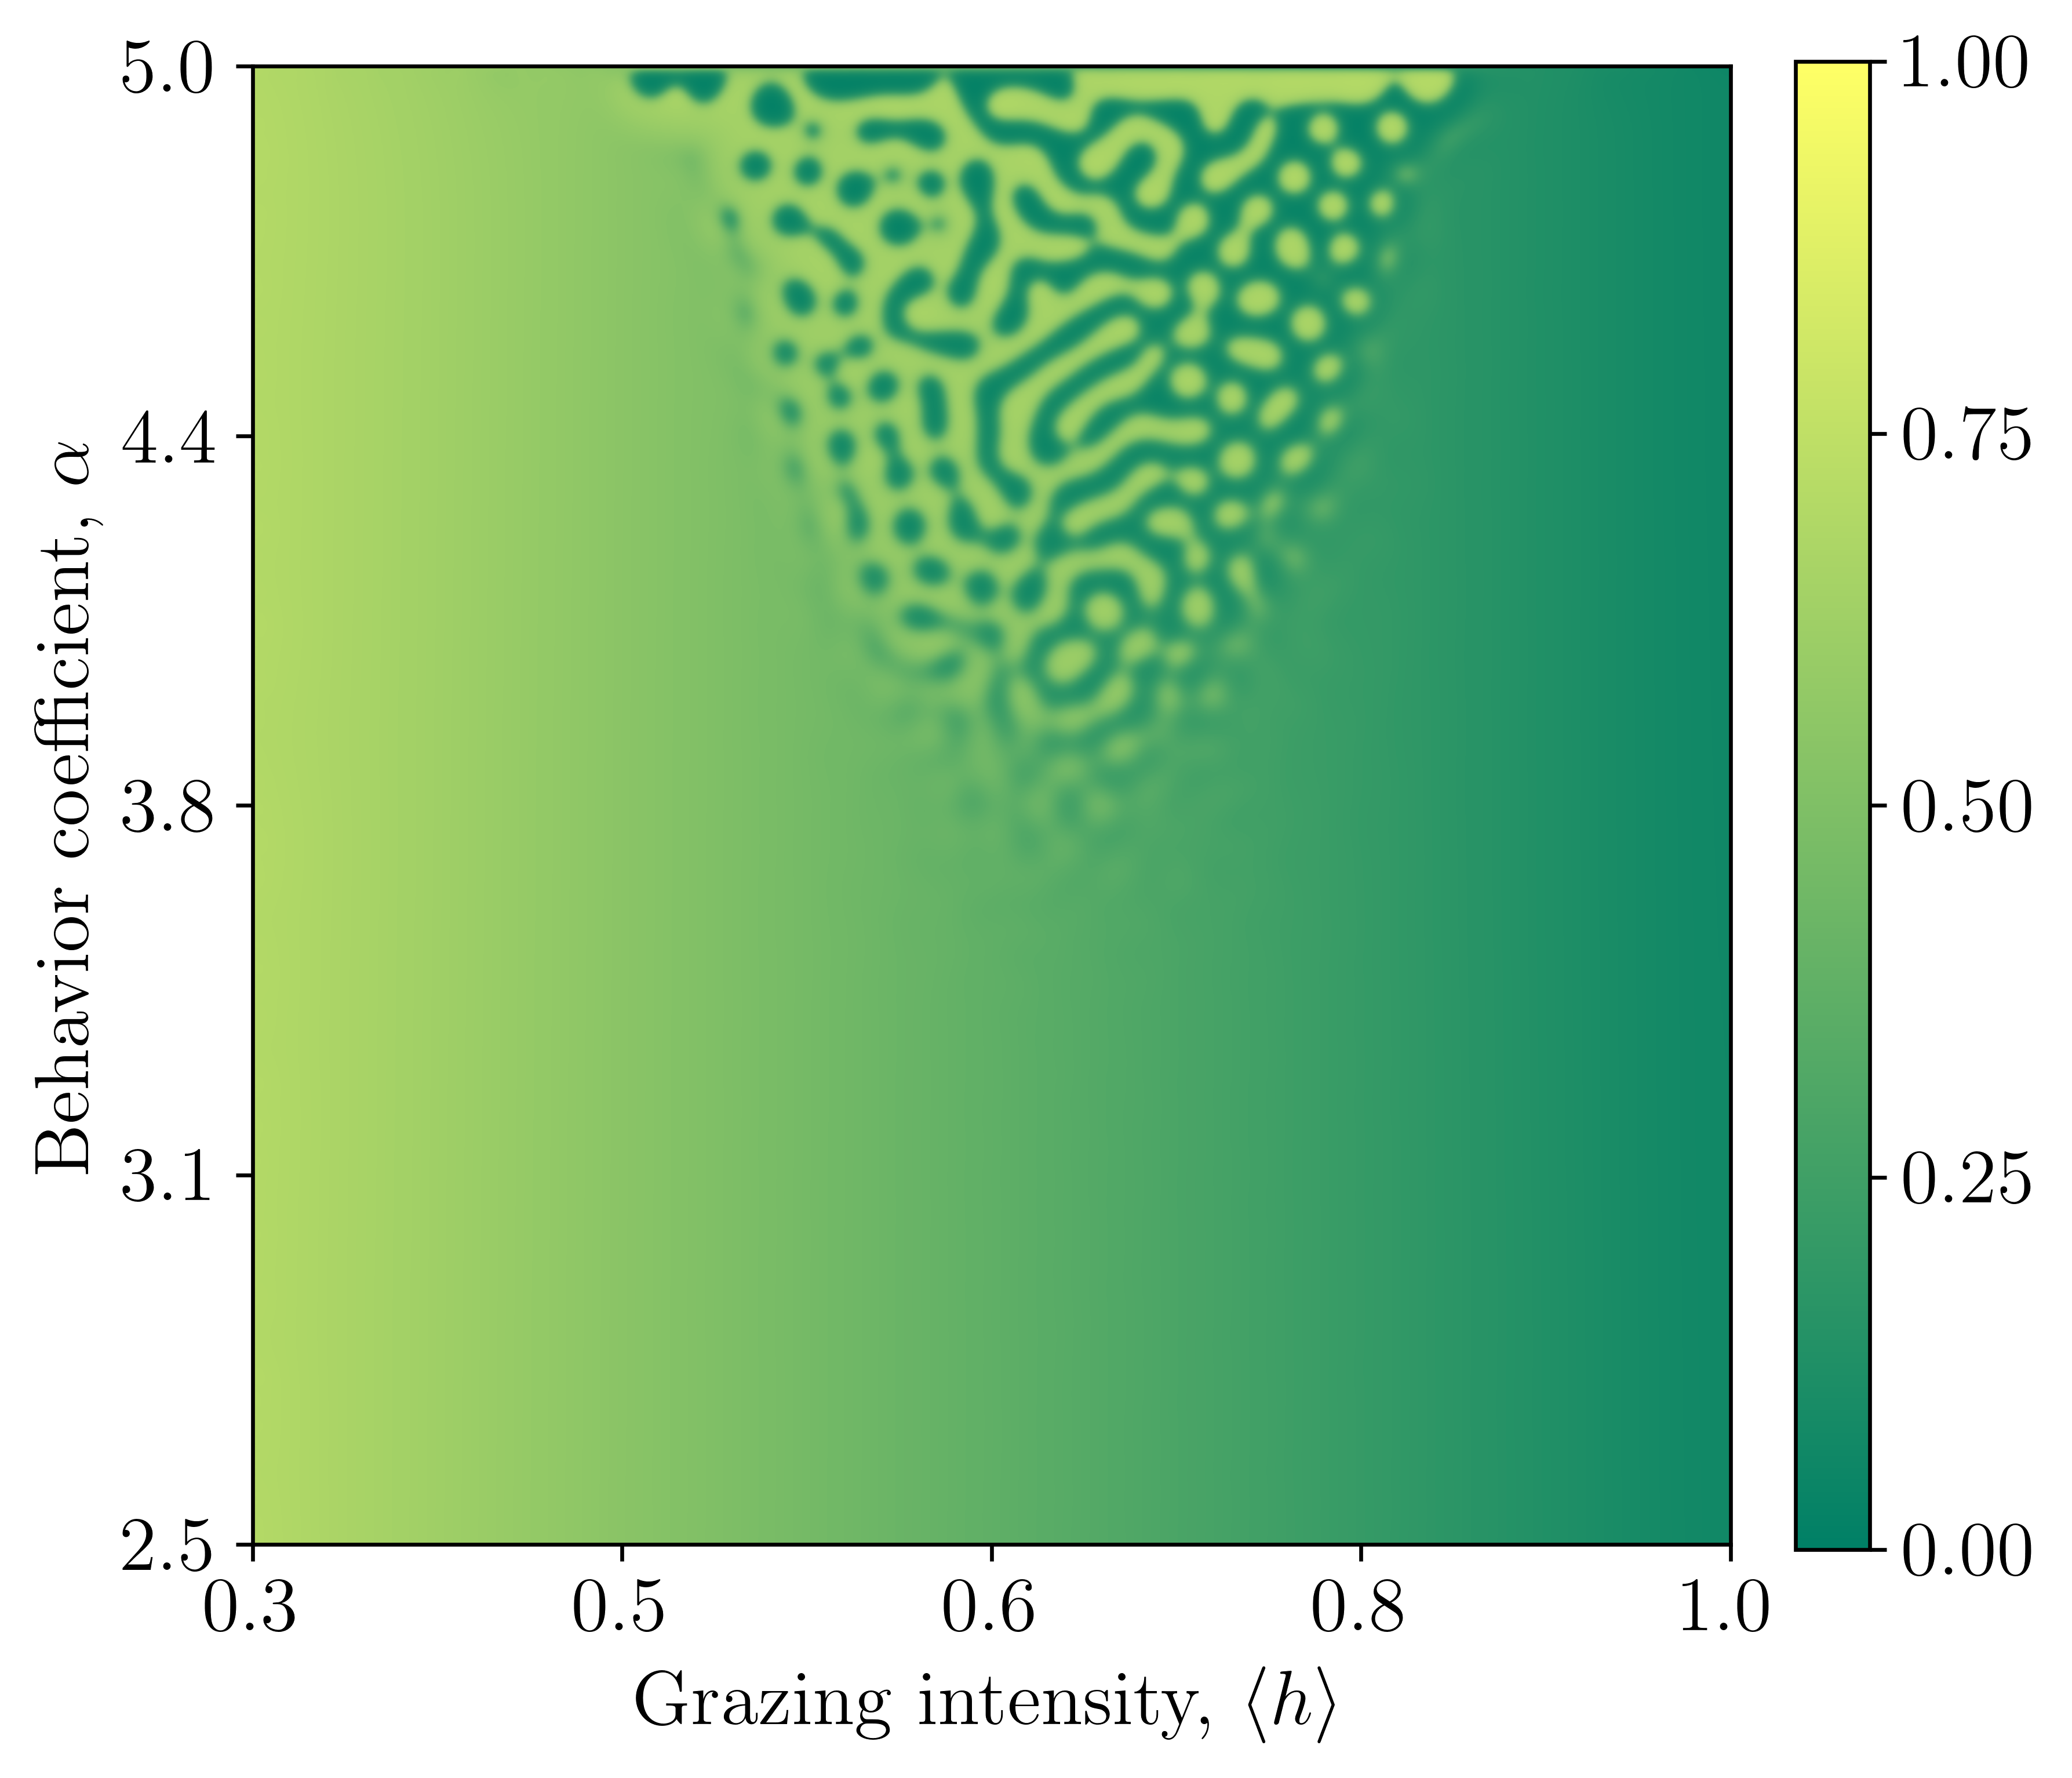

In [80]:
### plot the final plant state
nticker=5
from matplotlib import ticker

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im0 = ax.imshow(P_host.reshape(n,n),cmap='summer',extent=[0,length,0,length],clim=(0,1.0)) #, clim=(0,0.1));
#ax.set_title('S');
ax.set_xlabel(r'Grazing intensity, $\langle h \rangle$',) # 'Initial stone concentrations,
ax.set_ylabel(r'Behavior coefficient, $\alpha$')
cbar=plt.colorbar(im0, ax=ax,fraction=0.046,pad=0.04)
# ax[0].set_yticks(np.linspace(0,length,nticker))
tick_locator = ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()
Xlabels = np.linspace(H_min,H_max,nticker).round(1) # np.logspace(np.log10(S0_min),np.log10(S0_max),nticker)
Ylabels = np.linspace(alpha_min,alpha_max,nticker).round(1)
ax.set_xticks(np.linspace(0,length,nticker))
ax.set_xticklabels(Xlabels)
ax.set_yticks(np.linspace(0,length,nticker))
ax.set_yticklabels(Ylabels)


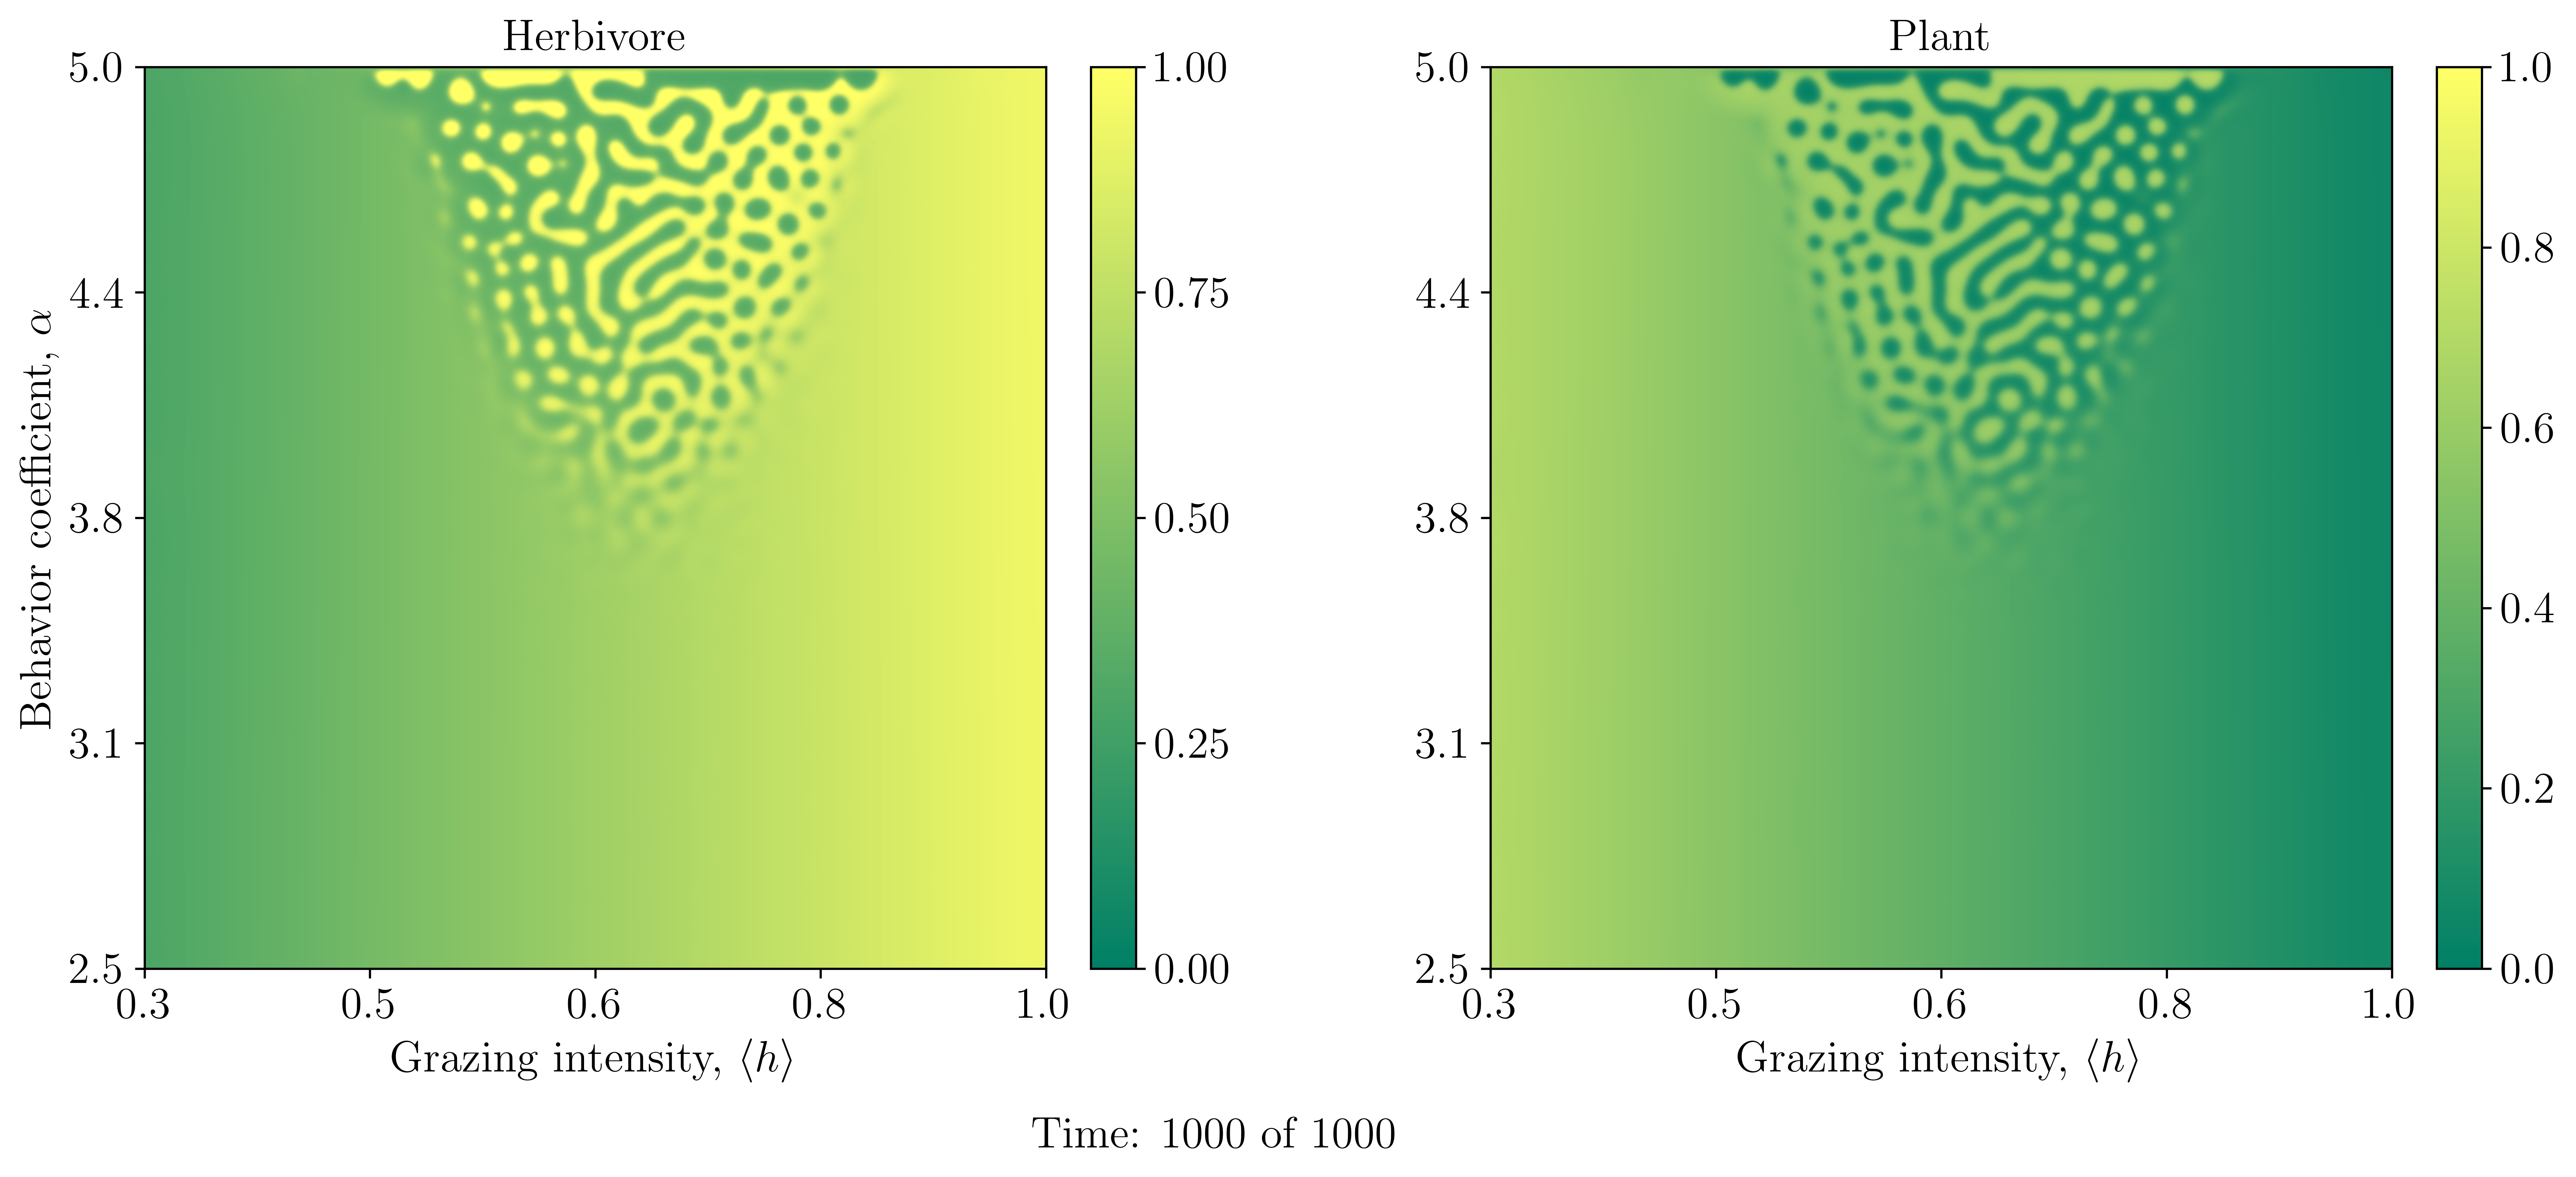

In [81]:
from matplotlib import ticker
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
im0 = ax[0].imshow(H_host.reshape(n,n),cmap='summer',extent=[0,length,0,length],clim=(0,1.0)) #, clim=(0,0.1));
ax[0].set_title('Herbivore')
ax[0].set_xlabel(r'Grazing intensity, $\langle h \rangle$')
ax[0].set_ylabel(r'Behavior coefficient, $\alpha$')
cbar=plt.colorbar(im0, ax=ax[0],fraction=0.046,pad=0.04)
# ax[0].set_yticks(np.linspace(0,length,nticker))
tick_locator = ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()
Xlabels = np.linspace(H_min,H_max,nticker).round(1) # np.logspace(np.log10(S0_min),np.log10(S0_max),nticker)
Ylabels = np.linspace(alpha_min,alpha_max,nticker).round(1)
ax[0].set_xticks(np.linspace(0,length,nticker))
ax[0].set_xticklabels(Xlabels)
ax[0].set_yticks(np.linspace(0,length,nticker))
ax[0].set_yticklabels(Ylabels)


im1 = ax[1].imshow(P_host.reshape(n,n),cmap='summer',extent=[0,length,0,length],clim=(0,1.0)) #, clim=(0,0.5));
ax[1].set_title('Plant')
ax[1].set_xlabel(r'Grazing intensity, $\langle{h}\rangle$')
# ax[1].set_ylabel('Movement speed decay rate, $\lambda$');
cbar=plt.colorbar(im1, ax=ax[1],fraction=0.046,pad=0.04)
# ax[1].set_yticks(np.linspace(0,length,nticker))
tick_locator = ticker.MaxNLocator(nbins=nticker)
cbar.locator = tick_locator
cbar.update_ticks()
# Xlabels = np.linspace(3.0,11.0,nticker)
# Ylabels = np.logspace(np.log10(0.01),np.log10(1.0),nticker)
ax[1].set_xticks(np.linspace(0,length,nticker))
ax[1].set_xticklabels(Xlabels)
ax[1].set_yticks(np.linspace(0,length,nticker))
ax[1].set_yticklabels(Ylabels)

text=fig.suptitle("Time: %1.0f of %1.0f" % (endtime, endtime), x=0.5, y=0.0, fontsize=16);

**Making a movie**

In [82]:
# from matplotlib import animation, rc

# def updatefig(i): # To update the image at each iteration
#     global As, Bs
#     im0.set_array(As[:,:,i])
#     im1.set_array(Bs[:,:,i])
#     #text.set_text("Time: %1.0f of %1.0f" % ((i+1)/nplot*endtime, endtime));
#     #fig.savefig('Data/Images'+str(i)+'.pdf',bbox_inches='tight')
#     return im0,im1,

# ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = nplot, repeat=False, blit=True)
# print("Save figure finshes!")